In [1]:
import pandas as pd
import fnmatch
import cv2
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import pickle
import time
import keras
from sklearn.model_selection import train_test_split
import keras_metrics
import matplotlib.pyplot as plt


In [2]:
#AlexNet Architecture for pH estimation
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(300,300,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 384)       8

In [3]:
#Reading data lab tested data in csv
Lab_tested_data = pd.read_csv('C:\\Users\\Mahmood Yousaf\\Desktop\\FYP\\Final-Year-Project-Soil-Analysis-using-machine-learning\\Lab Results\\Lab_tested_results.csv')

In [4]:
print(len(Lab_tested_data))
#Getting sample id for each image with its lab value
Sample_ID = Lab_tested_data.iloc[:,0]
pH_Value = Lab_tested_data.iloc[:,2]

1572


In [5]:
def load_images_from_folder(folder):
    Labels = []
    image_counter = 0
    for filename in os.listdir(folder):
        x = filename.split("_")
        id = float(x[0])
        img = cv2.imread(os.path.join(folder,filename))
        width = 1000
        height = 1000
        dim = (width, height)
        # resize image
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        img = img[500:800,500:800] #Resizing the image
        kernel = np.array([[-1,-1,-1], 
                   [-1, 9,-1],
                   [-1,-1,-1]])
        img = cv2.filter2D(img, -1, kernel) # applying the sharpening kernel.
        Result = Sample_ID.isin([id])
        Result = Sample_ID[Result];
        if len(Result) >= 1:
            print(image_counter)
            image_counter = image_counter + 1
            if len(Result) == 2:  
                Result = Sample_ID[Sample_ID==Result.iloc[1]].index.tolist()
                Id_1_index = Result[0]
                Id_2_index = Result[1]
                #Average of both inner and surface image soil result 
                pH_lab_value = (pH_Value[Id_2_index] + pH_Value[Id_2_index]) / 2
                #Assigning classs number 0,1,2,3
                if pH_lab_value >= 7.0 and pH_lab_value <= 7.5:
                    Labels.append([filename,img,0])
                elif pH_lab_value > 7.5 and pH_lab_value <= 8.0:
                    Labels.append([filename,img,1])
                elif pH_lab_value > 8.0 and pH_lab_value <= 8.5:
                    Labels.append([filename,img,2])
                elif pH_lab_value > 8.5:
                    Labels.append([filename,img,3])
            elif len(Result==1):
                Result = Sample_ID[Sample_ID==Result.iloc[1]].index.tolist()
                Id_1_index = Result[0]
                pH_lab_value = pH_Value[Id_1_index]
                #Assigning classs number 0,1,2,3,4
                if pH_lab_value >= 7.0 and pH_lab_value <= 7.5:
                    Labels.append([filename,img,0])
                elif pH_lab_value > 7.5 and pH_lab_value <= 8.0:
                    Labels.append([filename,img,1])
                elif pH_lab_value > 8.0 and pH_lab_value <= 8.5:
                    Labels.append([filename,img,2])
                elif pH_lab_value > 8.5:
                    Labels.append([filename,img,3])
        else:
            print(len(Result))
            continue
    return Labels

In [6]:
#loading dataset 
dataset = load_images_from_folder('C:\\Users\\Mahmood Yousaf\\Desktop\\FYP\\Dataset RGB\\Training_data')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
#Preparing data for model
X = []
Y = []
for data in dataset:
    X.append(data[1])
    Y.append(data[2])
print(Y)
print(len(X))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [8]:
img_size = 300
X = np.array(X).reshape(-1, img_size, img_size, 3)
print(X[0].shape)
Y = np.array(Y)
Y = to_categorical(Y,3)
print(X.shape)

(300, 300, 3)
(1064, 300, 300, 3)


In [9]:
print(X.shape)
X_train, X_val, y_train, y_val = train_test_split(X, Y)
print(Y.shape)

(1064, 300, 300, 3)
(1064, 3)


In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])
history=model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_split=0.4)

Epoch 1/1000


C:\Users\Mahmood Yousaf\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


15/15 [==============================] - 13s 437ms/step - loss: 42.5684 - accuracy: 0.6757 - precision: 0.0554 - recall: 0.1836 - f1_score: 0.0744 - val_loss: 1821.3896 - val_accuracy: 0.8594 - val_precision: 0.0444 - val_recall: 0.0459 - val_f1_score: 0.0448
Epoch 2/1000
15/15 [==============================] - 3s 207ms/step - loss: 17.9671 - accuracy: 0.7364 - precision: 0.0437 - recall: 0.0399 - f1_score: 0.0417 - val_loss: 364.2324 - val_accuracy: 0.8594 - val_precision: 0.0380 - val_recall: 0.0305 - val_f1_score: 0.0338
Epoch 3/1000
15/15 [==============================] - 3s 207ms/step - loss: 12.7695 - accuracy: 0.7469 - precision: 0.0476 - recall: 0.0359 - f1_score: 0.0409 - val_loss: 258.5615 - val_accuracy: 0.8594 - val_precision: 0.0510 - val_recall: 0.0327 - val_f1_score: 0.0399
Epoch 4/1000
15/15 [==============================] - 3s 207ms/step - loss: 12.8012 - accuracy: 0.7427 - precision: 0.0746 - recall: 0.0506 - f1_score: 0.0603 - val_loss: 52.9287 - val_accuracy: 0.8

15/15 [==============================] - 3s 207ms/step - loss: 1.5511 - accuracy: 0.8285 - precision: 0.1172 - recall: 0.0324 - f1_score: 0.0508 - val_loss: 16.2640 - val_accuracy: 0.8562 - val_precision: 0.1162 - val_recall: 0.0317 - val_f1_score: 0.0499
Epoch 21/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.8754 - accuracy: 0.8222 - precision: 0.1170 - recall: 0.0317 - f1_score: 0.0499 - val_loss: 1.0871 - val_accuracy: 0.8219 - val_precision: 0.1196 - val_recall: 0.0320 - val_f1_score: 0.0505
Epoch 22/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.6353 - accuracy: 0.8243 - precision: 0.1207 - recall: 0.0325 - f1_score: 0.0512 - val_loss: 1.2697 - val_accuracy: 0.8531 - val_precision: 0.1191 - val_recall: 0.0322 - val_f1_score: 0.0507
Epoch 23/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.9524 - accuracy: 0.8243 - precision: 0.1185 - recall: 0.0322 - f1_score: 0.0506 - val_loss: 1.5116 - val_accuracy: 0.8594 - val

15/15 [==============================] - 3s 208ms/step - loss: 0.5098 - accuracy: 0.8619 - precision: 0.1788 - recall: 0.0520 - f1_score: 0.0806 - val_loss: 2.2464 - val_accuracy: 0.6406 - val_precision: 0.1811 - val_recall: 0.0528 - val_f1_score: 0.0817
Epoch 51/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.4771 - accuracy: 0.8473 - precision: 0.1823 - recall: 0.0532 - f1_score: 0.0824 - val_loss: 2.2242 - val_accuracy: 0.7281 - val_precision: 0.1846 - val_recall: 0.0539 - val_f1_score: 0.0835
Epoch 52/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.5035 - accuracy: 0.8808 - precision: 0.1893 - recall: 0.0553 - f1_score: 0.0857 - val_loss: 3.3438 - val_accuracy: 0.6031 - val_precision: 0.1913 - val_recall: 0.0557 - val_f1_score: 0.0863
Epoch 53/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.5705 - accuracy: 0.8661 - precision: 0.1960 - recall: 0.0573 - f1_score: 0.0886 - val_loss: 2.3384 - val_accuracy: 0.6844 - val_

15/15 [==============================] - 3s 208ms/step - loss: 0.2528 - accuracy: 0.9184 - precision: 0.2785 - recall: 0.0974 - f1_score: 0.1443 - val_loss: 3.8380 - val_accuracy: 0.8281 - val_precision: 0.2827 - val_recall: 0.0989 - val_f1_score: 0.1466
Epoch 81/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.1948 - accuracy: 0.9331 - precision: 0.2869 - recall: 0.1007 - f1_score: 0.1491 - val_loss: 3.8179 - val_accuracy: 0.8500 - val_precision: 0.2915 - val_recall: 0.1025 - val_f1_score: 0.1517
Epoch 82/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.1707 - accuracy: 0.9351 - precision: 0.2959 - recall: 0.1044 - f1_score: 0.1544 - val_loss: 4.7555 - val_accuracy: 0.7875 - val_precision: 0.2979 - val_recall: 0.1063 - val_f1_score: 0.1567
Epoch 83/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.2178 - accuracy: 0.9498 - precision: 0.3018 - recall: 0.1092 - f1_score: 0.1604 - val_loss: 4.6962 - val_accuracy: 0.8250 - val_

15/15 [==============================] - 3s 208ms/step - loss: 0.5960 - accuracy: 0.8870 - precision: 0.3606 - recall: 0.1575 - f1_score: 0.2192 - val_loss: 314.0285 - val_accuracy: 0.8594 - val_precision: 0.3613 - val_recall: 0.1575 - val_f1_score: 0.2193
Epoch 111/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.8632 - accuracy: 0.8745 - precision: 0.3622 - recall: 0.1579 - f1_score: 0.2199 - val_loss: 3.1418 - val_accuracy: 0.8438 - val_precision: 0.3627 - val_recall: 0.1582 - val_f1_score: 0.2203
Epoch 112/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.4390 - accuracy: 0.8745 - precision: 0.3632 - recall: 0.1588 - f1_score: 0.2210 - val_loss: 2.9234 - val_accuracy: 0.8594 - val_precision: 0.3648 - val_recall: 0.1595 - val_f1_score: 0.2219
Epoch 113/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.6397 - accuracy: 0.9017 - precision: 0.3659 - recall: 0.1600 - f1_score: 0.2227 - val_loss: 210.5000 - val_accuracy: 0.8594

15/15 [==============================] - 3s 208ms/step - loss: 0.1552 - accuracy: 0.9644 - precision: 0.4092 - recall: 0.1960 - f1_score: 0.2650 - val_loss: 44.0981 - val_accuracy: 0.8625 - val_precision: 0.4110 - val_recall: 0.1968 - val_f1_score: 0.2661
Epoch 141/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.1217 - accuracy: 0.9749 - precision: 0.4134 - recall: 0.1982 - f1_score: 0.2680 - val_loss: 16.8971 - val_accuracy: 0.8156 - val_precision: 0.4142 - val_recall: 0.1992 - val_f1_score: 0.2690
Epoch 142/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.1435 - accuracy: 0.9665 - precision: 0.4156 - recall: 0.2004 - f1_score: 0.2705 - val_loss: 15.5891 - val_accuracy: 0.8531 - val_precision: 0.4174 - val_recall: 0.2014 - val_f1_score: 0.2717
Epoch 143/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.0820 - accuracy: 0.9728 - precision: 0.4193 - recall: 0.2026 - f1_score: 0.2732 - val_loss: 11.8782 - val_accuracy: 0.8594

15/15 [==============================] - 3s 208ms/step - loss: 0.6857 - accuracy: 0.8933 - precision: 0.4818 - recall: 0.2448 - f1_score: 0.3247 - val_loss: 23.2328 - val_accuracy: 0.8531 - val_precision: 0.4823 - val_recall: 0.2450 - val_f1_score: 0.3249
Epoch 171/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.5959 - accuracy: 0.9393 - precision: 0.4831 - recall: 0.2455 - f1_score: 0.3256 - val_loss: 26.1758 - val_accuracy: 0.8250 - val_precision: 0.4838 - val_recall: 0.2459 - val_f1_score: 0.3260
Epoch 172/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.4885 - accuracy: 0.9331 - precision: 0.4846 - recall: 0.2466 - f1_score: 0.3269 - val_loss: 21.3974 - val_accuracy: 0.8344 - val_precision: 0.4852 - val_recall: 0.2469 - val_f1_score: 0.3273
Epoch 173/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.3537 - accuracy: 0.9226 - precision: 0.4856 - recall: 0.2475 - f1_score: 0.3279 - val_loss: 19.3212 - val_accuracy: 0.8469

15/15 [==============================] - 3s 208ms/step - loss: 0.2574 - accuracy: 0.9749 - precision: 0.5153 - recall: 0.2785 - f1_score: 0.3616 - val_loss: 10.4444 - val_accuracy: 0.8062 - val_precision: 0.5160 - val_recall: 0.2791 - val_f1_score: 0.3623
Epoch 201/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.2606 - accuracy: 0.9812 - precision: 0.5168 - recall: 0.2799 - f1_score: 0.3632 - val_loss: 9.9781 - val_accuracy: 0.8313 - val_precision: 0.5173 - val_recall: 0.2803 - val_f1_score: 0.3636
Epoch 202/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.3224 - accuracy: 0.9665 - precision: 0.5179 - recall: 0.2813 - f1_score: 0.3646 - val_loss: 15.3408 - val_accuracy: 0.8656 - val_precision: 0.5184 - val_recall: 0.2815 - val_f1_score: 0.3649
Epoch 203/1000
15/15 [==============================] - 3s 208ms/step - loss: 1.0193 - accuracy: 0.9644 - precision: 0.5195 - recall: 0.2821 - f1_score: 0.3656 - val_loss: 10.3334 - val_accuracy: 0.8125 

15/15 [==============================] - 3s 208ms/step - loss: 1.0550 - accuracy: 0.9749 - precision: 0.5526 - recall: 0.3061 - f1_score: 0.3940 - val_loss: 39.7689 - val_accuracy: 0.8531 - val_precision: 0.5532 - val_recall: 0.3065 - val_f1_score: 0.3944
Epoch 231/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.3523 - accuracy: 0.9686 - precision: 0.5537 - recall: 0.3071 - f1_score: 0.3950 - val_loss: 37.3622 - val_accuracy: 0.8625 - val_precision: 0.5544 - val_recall: 0.3074 - val_f1_score: 0.3955
Epoch 232/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.1027 - accuracy: 0.9916 - precision: 0.5553 - recall: 0.3080 - f1_score: 0.3962 - val_loss: 32.1881 - val_accuracy: 0.8531 - val_precision: 0.5562 - val_recall: 0.3084 - val_f1_score: 0.3968
Epoch 233/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.1643 - accuracy: 0.9854 - precision: 0.5571 - recall: 0.3090 - f1_score: 0.3975 - val_loss: 30.3717 - val_accuracy: 0.8375

15/15 [==============================] - 3s 209ms/step - loss: 0.0727 - accuracy: 0.9895 - precision: 0.5857 - recall: 0.3293 - f1_score: 0.4216 - val_loss: 31.9455 - val_accuracy: 0.8500 - val_precision: 0.5864 - val_recall: 0.3296 - val_f1_score: 0.4220
Epoch 261/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.1402 - accuracy: 0.9833 - precision: 0.5870 - recall: 0.3299 - f1_score: 0.4224 - val_loss: 30.9110 - val_accuracy: 0.8438 - val_precision: 0.5877 - val_recall: 0.3302 - val_f1_score: 0.4228
Epoch 262/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.0968 - accuracy: 0.9916 - precision: 0.5885 - recall: 0.3307 - f1_score: 0.4235 - val_loss: 34.8162 - val_accuracy: 0.8500 - val_precision: 0.5890 - val_recall: 0.3309 - val_f1_score: 0.4238
Epoch 263/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.0979 - accuracy: 0.9937 - precision: 0.5898 - recall: 0.3315 - f1_score: 0.4244 - val_loss: 41.5675 - val_accuracy: 0.8594

15/15 [==============================] - 3s 209ms/step - loss: 0.0152 - accuracy: 0.9979 - precision: 0.6161 - recall: 0.3534 - f1_score: 0.4492 - val_loss: 34.1905 - val_accuracy: 0.8219 - val_precision: 0.6163 - val_recall: 0.3536 - val_f1_score: 0.4493
Epoch 291/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.3442 - accuracy: 0.9895 - precision: 0.6167 - recall: 0.3540 - f1_score: 0.4498 - val_loss: 44.2249 - val_accuracy: 0.8594 - val_precision: 0.6172 - val_recall: 0.3542 - val_f1_score: 0.4501
Epoch 292/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.1982 - accuracy: 0.9874 - precision: 0.6179 - recall: 0.3546 - f1_score: 0.4506 - val_loss: 123.8034 - val_accuracy: 0.8656 - val_precision: 0.6184 - val_recall: 0.3548 - val_f1_score: 0.4509
Epoch 293/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.1096 - accuracy: 0.9937 - precision: 0.6190 - recall: 0.3552 - f1_score: 0.4514 - val_loss: 88.8575 - val_accuracy: 0.856

15/15 [==============================] - 3s 209ms/step - loss: 0.1263 - accuracy: 0.9916 - precision: 0.6372 - recall: 0.3695 - f1_score: 0.4677 - val_loss: 34.1493 - val_accuracy: 0.8313 - val_precision: 0.6375 - val_recall: 0.3697 - val_f1_score: 0.4680
Epoch 321/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.2901 - accuracy: 0.9874 - precision: 0.6377 - recall: 0.3701 - f1_score: 0.4684 - val_loss: 51.8412 - val_accuracy: 0.8625 - val_precision: 0.6381 - val_recall: 0.3702 - val_f1_score: 0.4685
Epoch 322/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.3871 - accuracy: 0.9874 - precision: 0.6385 - recall: 0.3705 - f1_score: 0.4689 - val_loss: 61.7889 - val_accuracy: 0.8625 - val_precision: 0.6390 - val_recall: 0.3706 - val_f1_score: 0.4691
Epoch 323/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.3618 - accuracy: 0.9874 - precision: 0.6395 - recall: 0.3710 - f1_score: 0.4696 - val_loss: 53.9925 - val_accuracy: 0.8500

15/15 [==============================] - 3s 208ms/step - loss: 1.7289 - accuracy: 0.9916 - precision: 0.6518 - recall: 0.3843 - f1_score: 0.4836 - val_loss: 68.0473 - val_accuracy: 0.8469 - val_precision: 0.6522 - val_recall: 0.3845 - val_f1_score: 0.4838
Epoch 351/1000
15/15 [==============================] - 3s 208ms/step - loss: 2.4329 - accuracy: 0.9833 - precision: 0.6524 - recall: 0.3847 - f1_score: 0.4840 - val_loss: 36.2796 - val_accuracy: 0.7219 - val_precision: 0.6515 - val_recall: 0.3849 - val_f1_score: 0.4839
Epoch 352/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.6975 - accuracy: 0.9812 - precision: 0.6505 - recall: 0.3853 - f1_score: 0.4840 - val_loss: 28.9654 - val_accuracy: 0.8094 - val_precision: 0.6504 - val_recall: 0.3855 - val_f1_score: 0.4841
Epoch 353/1000
15/15 [==============================] - 3s 208ms/step - loss: 4.2365 - accuracy: 0.9728 - precision: 0.6504 - recall: 0.3857 - f1_score: 0.4842 - val_loss: 61.8997 - val_accuracy: 0.6187

15/15 [==============================] - 3s 208ms/step - loss: 0.0066 - accuracy: 0.9979 - precision: 0.6501 - recall: 0.3977 - f1_score: 0.4935 - val_loss: 68.8105 - val_accuracy: 0.8625 - val_precision: 0.6505 - val_recall: 0.3978 - val_f1_score: 0.4937
Epoch 381/1000
15/15 [==============================] - 3s 207ms/step - loss: 1.9306e-04 - accuracy: 1.0000 - precision: 0.6509 - recall: 0.3980 - f1_score: 0.4940 - val_loss: 74.2911 - val_accuracy: 0.8625 - val_precision: 0.6513 - val_recall: 0.3982 - val_f1_score: 0.4942
Epoch 382/1000
15/15 [==============================] - 3s 208ms/step - loss: 1.4575e-04 - accuracy: 1.0000 - precision: 0.6517 - recall: 0.3985 - f1_score: 0.4946 - val_loss: 73.7580 - val_accuracy: 0.8625 - val_precision: 0.6521 - val_recall: 0.3986 - val_f1_score: 0.4947
Epoch 383/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.1160 - accuracy: 0.9958 - precision: 0.6525 - recall: 0.3988 - f1_score: 0.4951 - val_loss: 73.1488 - val_accuracy

15/15 [==============================] - 3s 209ms/step - loss: 0.0273 - accuracy: 0.9979 - precision: 0.6459 - recall: 0.4099 - f1_score: 0.5015 - val_loss: 55.9681 - val_accuracy: 0.8406 - val_precision: 0.6462 - val_recall: 0.4100 - val_f1_score: 0.5017
Epoch 411/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.2118 - accuracy: 0.9958 - precision: 0.6466 - recall: 0.4102 - f1_score: 0.5020 - val_loss: 58.2346 - val_accuracy: 0.8438 - val_precision: 0.6470 - val_recall: 0.4103 - val_f1_score: 0.5021
Epoch 412/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.0787 - accuracy: 0.9958 - precision: 0.6473 - recall: 0.4105 - f1_score: 0.5024 - val_loss: 60.8108 - val_accuracy: 0.8000 - val_precision: 0.6476 - val_recall: 0.4106 - val_f1_score: 0.5025
Epoch 413/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.0526 - accuracy: 0.9979 - precision: 0.6480 - recall: 0.4108 - f1_score: 0.5028 - val_loss: 89.4461 - val_accuracy: 0.8594

15/15 [==============================] - 3s 208ms/step - loss: 3.3117e-07 - accuracy: 1.0000 - precision: 0.6568 - recall: 0.4202 - f1_score: 0.5125 - val_loss: 104.5113 - val_accuracy: 0.8562 - val_precision: 0.6571 - val_recall: 0.4203 - val_f1_score: 0.5126
Epoch 441/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.6574 - recall: 0.4205 - f1_score: 0.5129 - val_loss: 106.7860 - val_accuracy: 0.8562 - val_precision: 0.6577 - val_recall: 0.4206 - val_f1_score: 0.5131
Epoch 442/1000
15/15 [==============================] - 3s 207ms/step - loss: 0.4446 - accuracy: 0.9958 - precision: 0.6580 - recall: 0.4209 - f1_score: 0.5134 - val_loss: 88.1467 - val_accuracy: 0.8375 - val_precision: 0.6582 - val_recall: 0.4210 - val_f1_score: 0.5135
Epoch 443/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.0066 - accuracy: 0.9979 - precision: 0.6584 - recall: 0.4212 - f1_score: 0.5137 - val_loss: 85.6997 - val_accura

15/15 [==============================] - 3s 208ms/step - loss: 0.0901 - accuracy: 0.9958 - precision: 0.6697 - recall: 0.4293 - f1_score: 0.5232 - val_loss: 120.6298 - val_accuracy: 0.8562 - val_precision: 0.6699 - val_recall: 0.4293 - val_f1_score: 0.5233
Epoch 471/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.0682 - accuracy: 0.9979 - precision: 0.6702 - recall: 0.4295 - f1_score: 0.5235 - val_loss: 101.3094 - val_accuracy: 0.8469 - val_precision: 0.6705 - val_recall: 0.4295 - val_f1_score: 0.5236
Epoch 472/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.0774 - accuracy: 0.9958 - precision: 0.6707 - recall: 0.4297 - f1_score: 0.5239 - val_loss: 105.2037 - val_accuracy: 0.8375 - val_precision: 0.6709 - val_recall: 0.4298 - val_f1_score: 0.5240
Epoch 473/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.0932 - accuracy: 0.9979 - precision: 0.6711 - recall: 0.4300 - f1_score: 0.5242 - val_loss: 112.1174 - val_accuracy: 0.

15/15 [==============================] - 3s 208ms/step - loss: 0.0144 - accuracy: 0.9958 - precision: 0.6775 - recall: 0.4370 - f1_score: 0.5313 - val_loss: 111.4514 - val_accuracy: 0.7375 - val_precision: 0.6773 - val_recall: 0.4371 - val_f1_score: 0.5313
Epoch 501/1000
15/15 [==============================] - 3s 209ms/step - loss: 0.1354 - accuracy: 0.9979 - precision: 0.6771 - recall: 0.4373 - f1_score: 0.5314 - val_loss: 116.3148 - val_accuracy: 0.7531 - val_precision: 0.6768 - val_recall: 0.4373 - val_f1_score: 0.5313
Epoch 502/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.0370 - accuracy: 0.9958 - precision: 0.6765 - recall: 0.4376 - f1_score: 0.5314 - val_loss: 117.2431 - val_accuracy: 0.7844 - val_precision: 0.6765 - val_recall: 0.4376 - val_f1_score: 0.5314
Epoch 503/1000
15/15 [==============================] - 3s 208ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.6765 - recall: 0.4378 - f1_score: 0.5316 - val_loss: 118.7607 - val_accuracy

15/15 [==============================] - 3s 200ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.6858 - recall: 0.4441 - f1_score: 0.5391 - val_loss: 136.5807 - val_accuracy: 0.8500 - val_precision: 0.6860 - val_recall: 0.4442 - val_f1_score: 0.5392
Epoch 531/1000
15/15 [==============================] - 3s 199ms/step - loss: 7.4818e-10 - accuracy: 1.0000 - precision: 0.6863 - recall: 0.4444 - f1_score: 0.5395 - val_loss: 132.1082 - val_accuracy: 0.8500 - val_precision: 0.6864 - val_recall: 0.4444 - val_f1_score: 0.5395
Epoch 532/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.6866 - recall: 0.4446 - f1_score: 0.5397 - val_loss: 128.1589 - val_accuracy: 0.8500 - val_precision: 0.6868 - val_recall: 0.4447 - val_f1_score: 0.5398
Epoch 533/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.0577 - accuracy: 0.9979 - precision: 0.6870 - recall: 0.4449 - f1_score: 0.5401 - val_loss: 137.0837 - val_

15/15 [==============================] - 3s 199ms/step - loss: 0.4690 - accuracy: 0.9958 - precision: 0.6929 - recall: 0.4509 - f1_score: 0.5463 - val_loss: 136.6956 - val_accuracy: 0.8625 - val_precision: 0.6931 - val_recall: 0.4509 - val_f1_score: 0.5464
Epoch 561/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.8339 - accuracy: 0.9958 - precision: 0.6932 - recall: 0.4510 - f1_score: 0.5465 - val_loss: 91.9296 - val_accuracy: 0.8250 - val_precision: 0.6933 - val_recall: 0.4511 - val_f1_score: 0.5466
Epoch 562/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0369 - accuracy: 0.9979 - precision: 0.6935 - recall: 0.4513 - f1_score: 0.5468 - val_loss: 113.6222 - val_accuracy: 0.8125 - val_precision: 0.6937 - val_recall: 0.4514 - val_f1_score: 0.5469
Epoch 563/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.7452 - accuracy: 0.9916 - precision: 0.6940 - recall: 0.4516 - f1_score: 0.5471 - val_loss: 149.5646 - val_accuracy: 0.8

15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7027 - recall: 0.4568 - f1_score: 0.5537 - val_loss: 188.1509 - val_accuracy: 0.8375 - val_precision: 0.7028 - val_recall: 0.4569 - val_f1_score: 0.5538
Epoch 591/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.3906 - accuracy: 0.9979 - precision: 0.7030 - recall: 0.4570 - f1_score: 0.5539 - val_loss: 226.0934 - val_accuracy: 0.8500 - val_precision: 0.7031 - val_recall: 0.4570 - val_f1_score: 0.5540
Epoch 592/1000
15/15 [==============================] - 3s 199ms/step - loss: 1.7432 - accuracy: 0.9937 - precision: 0.7033 - recall: 0.4572 - f1_score: 0.5541 - val_loss: 171.6927 - val_accuracy: 0.8500 - val_precision: 0.7034 - val_recall: 0.4572 - val_f1_score: 0.5542
Epoch 593/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7036 - recall: 0.4574 - f1_score: 0.5544 - val_loss: 157.7269 - val_accu

15/15 [==============================] - 3s 200ms/step - loss: 0.2847 - accuracy: 0.9958 - precision: 0.7091 - recall: 0.4614 - f1_score: 0.5590 - val_loss: 197.6836 - val_accuracy: 0.8562 - val_precision: 0.7093 - val_recall: 0.4614 - val_f1_score: 0.5591
Epoch 621/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7095 - recall: 0.4615 - f1_score: 0.5593 - val_loss: 162.2134 - val_accuracy: 0.8406 - val_precision: 0.7096 - val_recall: 0.4615 - val_f1_score: 0.5593
Epoch 622/1000
15/15 [==============================] - 3s 199ms/step - loss: 1.3327 - accuracy: 0.9895 - precision: 0.7098 - recall: 0.4615 - f1_score: 0.5593 - val_loss: 152.6750 - val_accuracy: 0.8281 - val_precision: 0.7098 - val_recall: 0.4616 - val_f1_score: 0.5594
Epoch 623/1000
15/15 [==============================] - 3s 200ms/step - loss: 8.0053e-08 - accuracy: 1.0000 - precision: 0.7099 - recall: 0.4618 - f1_score: 0.5596 - val_loss: 161.4404 - val_accu

Epoch 650/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7150 - recall: 0.4660 - f1_score: 0.5643 - val_loss: 158.1257 - val_accuracy: 0.8313 - val_precision: 0.7150 - val_recall: 0.4660 - val_f1_score: 0.5643
Epoch 651/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.5300 - accuracy: 0.9979 - precision: 0.7150 - recall: 0.4662 - f1_score: 0.5644 - val_loss: 169.8988 - val_accuracy: 0.8313 - val_precision: 0.7150 - val_recall: 0.4662 - val_f1_score: 0.5644
Epoch 652/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0317 - accuracy: 0.9979 - precision: 0.7150 - recall: 0.4664 - f1_score: 0.5645 - val_loss: 191.1560 - val_accuracy: 0.7937 - val_precision: 0.7150 - val_recall: 0.4664 - val_f1_score: 0.5646
Epoch 653/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7150 - recall: 0.4666 - f1_score: 0.5647 - val_loss: 197.

Epoch 680/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7177 - recall: 0.4712 - f1_score: 0.5689 - val_loss: 194.0089 - val_accuracy: 0.8188 - val_precision: 0.7176 - val_recall: 0.4712 - val_f1_score: 0.5688
Epoch 681/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7176 - recall: 0.4713 - f1_score: 0.5690 - val_loss: 195.3109 - val_accuracy: 0.8156 - val_precision: 0.7175 - val_recall: 0.4714 - val_f1_score: 0.5689
Epoch 682/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7174 - recall: 0.4715 - f1_score: 0.5690 - val_loss: 196.7048 - val_accuracy: 0.8062 - val_precision: 0.7173 - val_recall: 0.4715 - val_f1_score: 0.5690
Epoch 683/1000
15/15 [==============================] - 3s 197ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7173 - recall: 0.4717 - f1_score: 0.5691 - val_lo

Epoch 710/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7206 - recall: 0.4751 - f1_score: 0.5727 - val_loss: 215.2212 - val_accuracy: 0.8375 - val_precision: 0.7207 - val_recall: 0.4752 - val_f1_score: 0.5727
Epoch 711/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.3744 - accuracy: 0.9979 - precision: 0.7209 - recall: 0.4753 - f1_score: 0.5729 - val_loss: 215.3638 - val_accuracy: 0.7781 - val_precision: 0.7211 - val_recall: 0.4753 - val_f1_score: 0.5729
Epoch 712/1000
15/15 [==============================] - 3s 200ms/step - loss: 1.1075 - accuracy: 0.9937 - precision: 0.7213 - recall: 0.4754 - f1_score: 0.5731 - val_loss: 205.7334 - val_accuracy: 0.7969 - val_precision: 0.7213 - val_recall: 0.4754 - val_f1_score: 0.5731
Epoch 713/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7214 - recall: 0.4755 - f1_score: 0.5732 - val_loss: 203.

Epoch 740/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.5206 - accuracy: 0.9958 - precision: 0.7260 - recall: 0.4790 - f1_score: 0.5772 - val_loss: 217.2165 - val_accuracy: 0.8031 - val_precision: 0.7260 - val_recall: 0.4790 - val_f1_score: 0.5772
Epoch 741/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.4205 - accuracy: 0.9958 - precision: 0.7260 - recall: 0.4791 - f1_score: 0.5773 - val_loss: 184.1654 - val_accuracy: 0.7844 - val_precision: 0.7259 - val_recall: 0.4792 - val_f1_score: 0.5773
Epoch 742/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.2417 - accuracy: 0.9979 - precision: 0.7258 - recall: 0.4793 - f1_score: 0.5773 - val_loss: 209.0600 - val_accuracy: 0.7625 - val_precision: 0.7255 - val_recall: 0.4794 - val_f1_score: 0.5773
Epoch 743/1000
15/15 [==============================] - 3s 199ms/step - loss: 2.3805 - accuracy: 0.9958 - precision: 0.7252 - recall: 0.4795 - f1_score: 0.5773 - val_loss: 285.9730 - v

15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7285 - recall: 0.4821 - f1_score: 0.5802 - val_loss: 235.6287 - val_accuracy: 0.8406 - val_precision: 0.7285 - val_recall: 0.4821 - val_f1_score: 0.5802
Epoch 771/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7286 - recall: 0.4822 - f1_score: 0.5803 - val_loss: 236.1558 - val_accuracy: 0.8406 - val_precision: 0.7287 - val_recall: 0.4822 - val_f1_score: 0.5804
Epoch 772/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.1303 - accuracy: 0.9979 - precision: 0.7288 - recall: 0.4824 - f1_score: 0.5805 - val_loss: 229.9891 - val_accuracy: 0.8125 - val_precision: 0.7287 - val_recall: 0.4823 - val_f1_score: 0.5804
Epoch 773/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.6396 - accuracy: 0.9958 - precision: 0.7286 - recall: 0.4824 - f1_score: 0.5805 - val_loss: 226.2360 - val_accu

Epoch 800/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7294 - recall: 0.4855 - f1_score: 0.5830 - val_loss: 250.6629 - val_accuracy: 0.8406 - val_precision: 0.7295 - val_recall: 0.4856 - val_f1_score: 0.5830
Epoch 801/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7296 - recall: 0.4857 - f1_score: 0.5832 - val_loss: 250.6943 - val_accuracy: 0.8406 - val_precision: 0.7296 - val_recall: 0.4857 - val_f1_score: 0.5832
Epoch 802/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7297 - recall: 0.4858 - f1_score: 0.5832 - val_loss: 250.9281 - val_accuracy: 0.8406 - val_precision: 0.7297 - val_recall: 0.4858 - val_f1_score: 0.5833
Epoch 803/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7298 - recall: 0.4859 - f1_score: 0.5834 - val_lo

Epoch 830/1000
15/15 [==============================] - 3s 199ms/step - loss: 1.9445e-04 - accuracy: 1.0000 - precision: 0.7339 - recall: 0.4887 - f1_score: 0.5868 - val_loss: 252.4036 - val_accuracy: 0.8375 - val_precision: 0.7340 - val_recall: 0.4888 - val_f1_score: 0.5868
Epoch 831/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7341 - recall: 0.4888 - f1_score: 0.5869 - val_loss: 251.4852 - val_accuracy: 0.8375 - val_precision: 0.7341 - val_recall: 0.4889 - val_f1_score: 0.5869
Epoch 832/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7342 - recall: 0.4890 - f1_score: 0.5870 - val_loss: 250.7756 - val_accuracy: 0.8375 - val_precision: 0.7343 - val_recall: 0.4890 - val_f1_score: 0.5871
Epoch 833/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7343 - recall: 0.4891 - f1_score: 0.5872 - val_lo

Epoch 860/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.3608 - accuracy: 0.9958 - precision: 0.7383 - recall: 0.4918 - f1_score: 0.5904 - val_loss: 260.3678 - val_accuracy: 0.8313 - val_precision: 0.7382 - val_recall: 0.4918 - val_f1_score: 0.5904
Epoch 861/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7382 - recall: 0.4919 - f1_score: 0.5904 - val_loss: 284.5392 - val_accuracy: 0.8562 - val_precision: 0.7383 - val_recall: 0.4919 - val_f1_score: 0.5905
Epoch 862/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.8895 - accuracy: 0.9979 - precision: 0.7384 - recall: 0.4921 - f1_score: 0.5906 - val_loss: 254.0398 - val_accuracy: 0.8562 - val_precision: 0.7385 - val_recall: 0.4921 - val_f1_score: 0.5906
Epoch 863/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7385 - recall: 0.4922 - f1_score: 0.5907 - val_loss: 217.

15/15 [==============================] - 3s 199ms/step - loss: 0.1483 - accuracy: 0.9979 - precision: 0.7417 - recall: 0.4944 - f1_score: 0.5933 - val_loss: 321.4114 - val_accuracy: 0.8594 - val_precision: 0.7418 - val_recall: 0.4944 - val_f1_score: 0.5934
Epoch 891/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7420 - recall: 0.4945 - f1_score: 0.5935 - val_loss: 309.8553 - val_accuracy: 0.8594 - val_precision: 0.7421 - val_recall: 0.4945 - val_f1_score: 0.5935
Epoch 892/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7422 - recall: 0.4946 - f1_score: 0.5936 - val_loss: 306.3321 - val_accuracy: 0.8562 - val_precision: 0.7423 - val_recall: 0.4946 - val_f1_score: 0.5936
Epoch 893/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7424 - recall: 0.4947 - f1_score: 0.5938 - val_loss: 303.6849 - val_

Epoch 920/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7476 - recall: 0.4970 - f1_score: 0.5970 - val_loss: 266.7431 - val_accuracy: 0.8281 - val_precision: 0.7476 - val_recall: 0.4970 - val_f1_score: 0.5970
Epoch 921/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0963 - accuracy: 0.9979 - precision: 0.7476 - recall: 0.4971 - f1_score: 0.5971 - val_loss: 288.6517 - val_accuracy: 0.8281 - val_precision: 0.7476 - val_recall: 0.4971 - val_f1_score: 0.5971
Epoch 922/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7476 - recall: 0.4972 - f1_score: 0.5972 - val_loss: 308.7061 - val_accuracy: 0.8406 - val_precision: 0.7476 - val_recall: 0.4972 - val_f1_score: 0.5972
Epoch 923/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7476 - recall: 0.4973 - f1_score: 0.5973 - val_loss: 

Epoch 950/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7508 - recall: 0.4997 - f1_score: 0.6000 - val_loss: 294.5240 - val_accuracy: 0.8406 - val_precision: 0.7509 - val_recall: 0.4997 - val_f1_score: 0.6001
Epoch 951/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7509 - recall: 0.4998 - f1_score: 0.6001 - val_loss: 295.3589 - val_accuracy: 0.8406 - val_precision: 0.7510 - val_recall: 0.4998 - val_f1_score: 0.6002
Epoch 952/1000
15/15 [==============================] - 3s 199ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7511 - recall: 0.4999 - f1_score: 0.6002 - val_loss: 295.9880 - val_accuracy: 0.8344 - val_precision: 0.7511 - val_recall: 0.4999 - val_f1_score: 0.6003
Epoch 953/1000
15/15 [==============================] - 3s 198ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7512 - recall: 0.5000 - f1_score: 0.6004 - val_lo

Epoch 980/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.8168 - accuracy: 0.9958 - precision: 0.7546 - recall: 0.5020 - f1_score: 0.6029 - val_loss: 269.8024 - val_accuracy: 0.8500 - val_precision: 0.7546 - val_recall: 0.5020 - val_f1_score: 0.6029
Epoch 981/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.9021 - accuracy: 0.9937 - precision: 0.7547 - recall: 0.5020 - f1_score: 0.6030 - val_loss: 316.7185 - val_accuracy: 0.8594 - val_precision: 0.7548 - val_recall: 0.5020 - val_f1_score: 0.6029
Epoch 982/1000
15/15 [==============================] - 3s 200ms/step - loss: 0.3145 - accuracy: 0.9979 - precision: 0.7549 - recall: 0.5020 - f1_score: 0.6030 - val_loss: 237.9437 - val_accuracy: 0.8250 - val_precision: 0.7549 - val_recall: 0.5020 - val_f1_score: 0.6030
Epoch 983/1000
15/15 [==============================] - 3s 200ms/step - loss: 2.5598 - accuracy: 0.9895 - precision: 0.7549 - recall: 0.5021 - f1_score: 0.6031 - val_loss: 294.7651 - v

In [11]:
model.evaluate(X_val,y_val)

9/9 [==============================] - 1s 146ms/step - loss: 683.5203 - accuracy: 0.8383 - precision: 0.7555 - recall: 0.5032 - f1_score: 0.6041


[683.5203247070312,
 0.8383458852767944,
 0.7555328607559204,
 0.5032248497009277,
 0.6040922403335571]

In [12]:
y_val[100]

array([0., 1., 0.], dtype=float32)

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


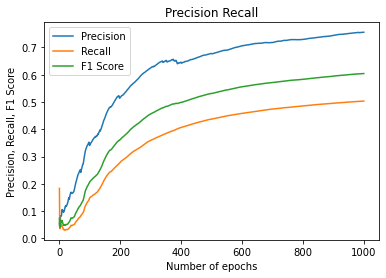

In [22]:
print(history.history.keys())
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['f1_score'])
plt.title('Precision Recall')
plt.ylabel('Precision, Recall, F1 Score')
plt.savefig("CnnClassificationMeasuresPH.jpg")
plt.xlabel('Number of epochs')
plt.legend(['Precision', 'Recall','F1 Score'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


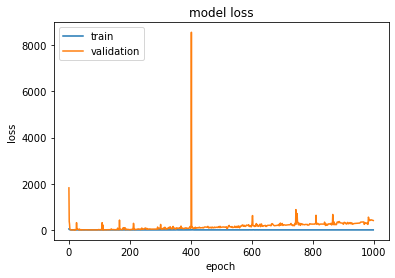

In [20]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.savefig("CnnClassificationModelLossPH.jpg")
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


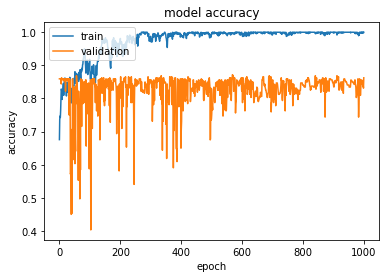

In [21]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("CnnClassificationModelAccuracyPH.jpg")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()